## Lab 1 - A-star

Implement the A* to the set cover problem

In [1]:
import numpy as np
from random import random
from functools import reduce
import queue
import matplotlib.pyplot as plt
from collections import namedtuple
import scipy
from math import factorial
from tqdm import tqdm

In [2]:
PROBLEM_SIZE = 25
NUM_SETS = 64
State = namedtuple('state', ['taken', 'not_taken'])
SETS = tuple(np.array([random() < .5 for _ in range(PROBLEM_SIZE)]) for _ in range(NUM_SETS))

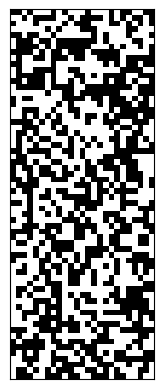

In [3]:
def draw_sol(map):
    plt.imshow(map, cmap="binary")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show();

draw_sol(np.vstack([SETS[i] for i in range(NUM_SETS)]))

In [4]:
def draw_plots(size, plots, xlabel="x", ylabel="y", legend_title=" "):
    for label in plots.keys():
        plt.plot(range(1, size), plots[label], label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(1, size))
    plt.legend(title=legend_title)
    plt.show()

In [5]:
def goal_check(state): # function to check if we found a set cover
    return len(state.taken) > 0 and np.all(reduce(np.logical_or, [SETS[i] for i in state.taken])) 

assert goal_check(State(set(range(NUM_SETS)), set())), "Problem not solvable" # check if the problem is solvable

In [6]:
def heur1(state):
    return PROBLEM_SIZE - np.sum(reduce(np.logical_or, [SETS[i] for i in state.taken], [False for _ in range(PROBLEM_SIZE)]))

In [7]:
def find_solution(f = lambda s: len(s.taken), verbose=True, ubound=10000): #f is the function that calculates the cost of reaching a state
    frontier = queue.PriorityQueue()
    frontier.put((0, State(set(), set(range(NUM_SETS)))))  #initial state
    _, curr_state = frontier.get()
    counter = 0
    while not goal_check(curr_state):
        counter += 1
        if ubound and ubound < counter:
            del frontier
            print("Computation timed out")
            return -1, counter
        for action in curr_state.not_taken:
            new_state = State(curr_state.taken ^ {action}, curr_state.not_taken ^ {action}) #using XOR for both operations
            frontier.put((f(new_state), new_state))
        _, curr_state = frontier.get()
    if verbose:
        print("Found solution", curr_state.taken ,"in", counter, "steps.\nCost:", len(curr_state.taken))
        draw_sol(np.vstack([SETS[i] for i in curr_state.taken]))
    del frontier
    return len(curr_state.taken), counter

Let's calculate solutions with breadth-first and greedy best-first algorithms to use them as a benchmark:

## Breadth First


Found solution {24, 44, 15} in 4110 steps.
Cost: 3


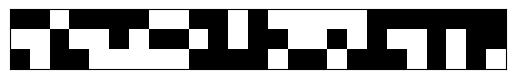

In [8]:
bf_cost, bf_steps = find_solution()

## Greedy Best First

Found solution {0, 5, 13} in 3 steps.
Cost: 3


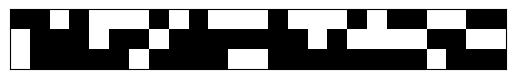

In [9]:
gbf_cost, gbf_steps = find_solution(heur1)

# A*

The metric used to calculate the priority is

    f(n) = g(n) + h(n)

- g is the cost
- h is the heuristic (distance)

## First approach

- g = number of sets taken
- h = number of spots left to fill

Found solution {0, 5, 13} in 6 steps.
Cost: 3


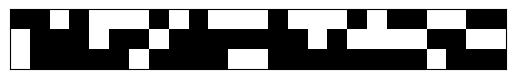

In [10]:
curr_cost, curr_steps = find_solution(lambda s: heur1(s) + len(s.taken))

### Observations:
The first approach doesn't provide any improvement when compared to greedy best first.

## Adding a weight to g(n)
Let's try adding a weight to each edge traversed.

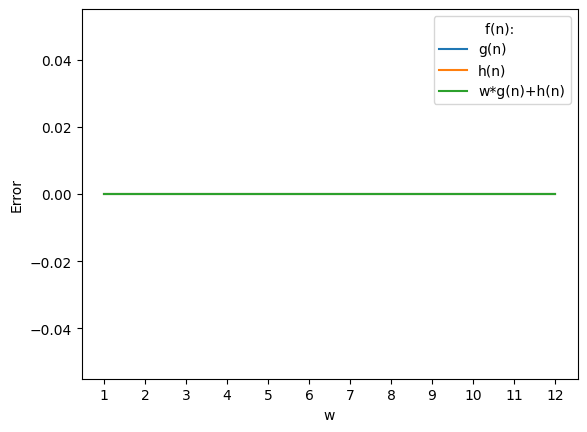

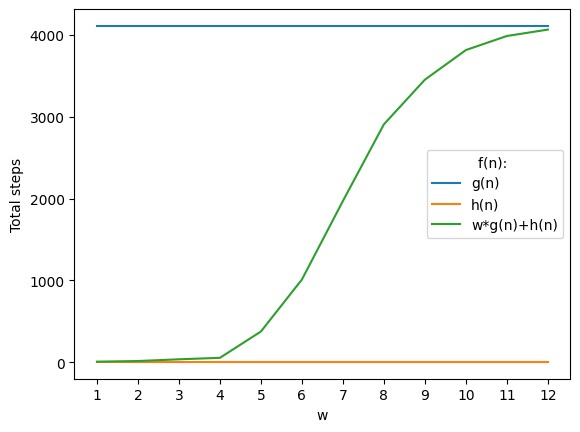

In [11]:
w = 1
costs = []
steps = []
costs.append(curr_cost - bf_cost)
steps.append(curr_steps)
for w in range(1, int(0.5 * PROBLEM_SIZE)):
            w += 1
            curr_cost, curr_steps = find_solution(lambda s: heur1(s) + w * len(s.taken), verbose=False)
            costs.append(curr_cost - bf_cost)
            steps.append(curr_steps)

draw_plots(w+1, plots={
    "g(n)": [0 for _ in range(1, w+1)],
    "h(n)": [gbf_cost - bf_cost for _ in range(1, w+1)],
    "w*g(n)+h(n)": costs
    },
    xlabel="w",
    ylabel="Error",
    legend_title="f(n): ")

draw_plots(w+1, plots={
    "g(n)": [bf_steps for _ in range(1, w+1)],
    "h(n)": [gbf_steps for _ in range(1, w+1)],
    "w*g(n)+h(n)": steps
    },
    xlabel="w",
    ylabel="Total steps",
    legend_title="f(n): ")

### Observations
Predictably, as w increases, the algorithm behaves more like uniform-cost search (becomes slower), however it reaches an optimal solution with relatively low values of w.

## Changing heuristics
Let's try changing h(n) to penalize repeated values

In [12]:
def heur2(state):
    mask = [0.5 if e > 1 else e for e in np.sum([SETS[i].astype(int) for i in state.taken], axis=0)]
    return PROBLEM_SIZE - np.sum(mask)

Found solution {2, 3, 13} in 8 steps.
Cost: 3


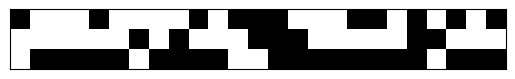

In [13]:
gbf_norep_cost, gbf_norep_steps = find_solution(heur2)

Found solution {56, 0, 45} in 847 steps.
Cost: 3


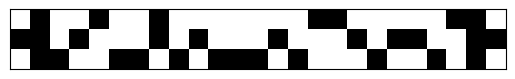

In [14]:
w = 0.5 * PROBLEM_SIZE/2
a_norep_cost, a_norep_steps = find_solution(lambda s: w * len(s.taken) + heur2(s))

Let's compare the results

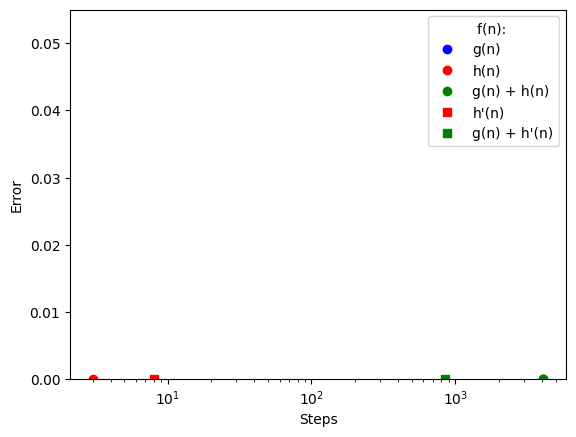

In [15]:
plt.plot(bf_steps, 0, 'bo', label="g(n)")
plt.plot(gbf_steps, gbf_cost - bf_cost, 'ro', label="h(n)")
plt.plot(steps[-1], costs[-1], 'go', label="g(n) + h(n)")
plt.plot(gbf_norep_steps, gbf_norep_cost - bf_cost, 'rs', label="h'(n)")
plt.plot(a_norep_steps, a_norep_cost - bf_cost, 'gs', label="g(n) + h'(n)")
plt.xlabel("Steps")
plt.ylabel("Error")
plt.legend(title="f(n): ")
ax = plt.gca()
ax.set_xscale('log')
ax.set_ybound(0.)
plt.show();

The results given by the second heuristic are comparable to those of the first.

### Approximating BFS

Up until now, we used BFS to calculate the optimal solution.
This works for small problems, but it becomes unfeasible for larger ones.
We can approximate the results of BFS by using linear programming to find an optimal solution, then calculate how much time it would have taken BFS to find that solution.

In [16]:
def approx_BFS():
    def BFS_steps(depth):  # calculates the number of steps taken by BFS to find a solution at given depth in the worst-case scenario
        steps = 0
        for d in range(1, depth+1):
            steps += factorial(NUM_SETS) / factorial(NUM_SETS - d)
        return steps
    objective = np.array([1 for _ in range(NUM_SETS)])
    constraint_mat = np.vstack((np.vstack([SETS[i].astype(int) * -1 for i in range(NUM_SETS)]).T, np.eye(NUM_SETS), np.eye(NUM_SETS) * -1))
    constraint_vec = np.hstack((np.array([-1 for _ in range(PROBLEM_SIZE)]), np.array([1 for _ in range(NUM_SETS)]), np.array([0 for _ in range(NUM_SETS)])))
    sol = np.where(scipy.optimize.linprog(objective, constraint_mat, constraint_vec, bounds=(0, 1), integrality=1).x>0.5)
    return set(sol[0]), int(BFS_steps(len(sol[0])))

In [17]:
def draw_points(P,  results):
    plt.title("Path searching algorithm performance with p = {}".format(P))
    plt.plot(results[0], results[1], 'ro', label="h(n)", alpha=0.2)
    plt.plot(results[2], results[3], 'go', label="{}g(n) + h(n)".format(P * PROBLEM_SIZE/2), alpha=0.2)
    plt.plot(results[4], results[5], 'ms', label="h'(n)", alpha=0.2)
    plt.plot(results[6], results[7], 'ys', label="{}g(n) + h'(n)".format(P * PROBLEM_SIZE/2), alpha=0.2)
    plt.xlabel("Steps")
    plt.ylabel("Error")
    plt.legend(title="f(n): ")
    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_ybound(0.)
    plt.show()

In [20]:
NUM_SETS = 512
PROBLEM_SIZE = 20
fs = {
    "h(n)": heur1,
    "g(n) + h(n)": lambda s: w * len(s.taken) + heur1(s),
    "h'(n)": heur2,
    "g(n) + h'(n)": lambda s: w * len(s.taken) + heur2(s),
}
results = {}
bfs_steps = {}
for P in (0.25, 0.5, 0.75):
    results[P] =[[] for _ in range(len(fs.keys()) * 2)]
    bfs_steps[P] = []
    w = PROBLEM_SIZE/2 * P
    for _ in tqdm(range(100), position=0, leave=True):
        SETS = tuple(np.array([random() < P for _ in range(PROBLEM_SIZE)]) for _ in range(NUM_SETS))
        assert goal_check(State(set(range(NUM_SETS)), set())), "Problem not solvable"
        aBFS_sol, aBFS_steps = approx_BFS()
        bf_steps[P].append(aBFS_steps)
        bfs_cost = len(aBFS_sol)
        for i, f in tqdm(enumerate(fs.keys()), position=1, leave=False):
            res_c, res_s = find_solution(fs[f], verbose=False)
            if res_c > -1:
                results[P][2*i].append(res_s)
                results[P][2*i+1].append(res_c - bfs_cost)

  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: 'int' object is not subscriptable

In [ ]:
for p in results.keys():
    draw_points(p, results[p])